In [263]:
!pip install tensorflow==2.5.0 tensorflow-gpu==2.5.0 opencv-python matplotlib --user

In [6]:



import tensorflow as tf
model=tf.keras.models.load_model("C:/Users/acer/siamesemodelv2.h5", custom_objects={'CustomLayer': CustomLayer})
y_hat = model.predict([test_input, test_val]) #predict is builtin function 
y_hat

ValueError: Unknown layer: L1Dist. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [ ]:
model.summary()

In [1]:
import os


'os.listdir' is not recognized as an internal or external command,
operable program or batch file.


In [264]:
pip install opencv-python 


Note: you may need to restart the kernel to use updated packages.


In [265]:
#importing dependecies 
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt

In [266]:
#import tensorflow depedencies- functional api- siamese nural network
#dense gives connected layer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer,Conv2D, Dense , MaxPooling2D, Input, Flatten
import tensorflow as tf

In [97]:
len(gpus)

0

In [171]:
#avoiding gpu to take over completly 
gpus= tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,False)

In [267]:
# setup paths
POS_PATH = os.path.join('data','positive')
NEG_PATH = os.path.join('data','negative')
ANC_PATH = os.path.join('data','anchor')

In [268]:
POS_PATH


'data\\positive'

In [269]:
#make the directories 
#os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\negative'

In [ ]:
####################################

In [ ]:
#extracting from the zip file 
!tar -xf lfw.tgz

In [ ]:
# moving all the image to negative data/negative 
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw',directory)):
        EX_PATH = (os.path.join('lfw',directory,file))
        NEW_PATH = (os.path.join(NEG_PATH,file))
        os.replace(EX_PATH,NEW_PATH)


In [270]:
#import uuid lib to generate unique image name 
import uuid

In [271]:
%config Completer.use_jedi = False

In [272]:
uuid.uuid1()

UUID('6d3cfc99-dc45-11ed-b151-e4aaea77320a')

In [273]:
#Establishing a connection with the webcam 
cam = cv2.VideoCapture(1)
while cam.isOpened():
    ret , frame = cam.read()
    
    #cutting down the frame 250*250px
    frame = frame[50:120+250,120:200+250,:]
    
    #collecting Anchor
    if cv2.waitKey(1) & 0xFF == ord('a'):
        #uuid naam generate karke dega 
        imgname = os.path.join(ANC_PATH,'{}.jpg'.format(uuid.uuid1()))
        #write out anchor image
        cv2.imwrite(imgname,frame)
        
    #collecting Positiveq
    if cv2.waitKey(1) & 0xFF == ord('p'):
        #uuid naam generate karke dega 
        imgname = os.path.join(POS_PATH,'{}.jpg'.format(uuid.uuid1()))
        #write out anchor image
        cv2.imwrite(imgname,frame)
        
    #show image on the screen 
    cv2.imshow('Image collection',frame)
    
    #breaking gracefully
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
#release the webcam 
cam.release()
#close the image show frame 
cv2.destroyAllWindows()


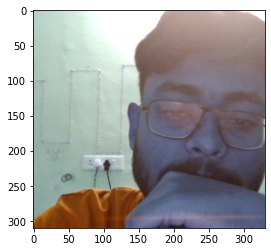

In [105]:
plt.imshow(frame)

In [106]:
frame.shape

(310, 330, 3)

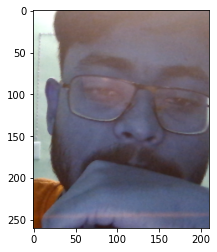

In [107]:
plt.imshow(frame[50:120+250,120:200+250,:])

In [ ]:
##################################

In [274]:
#grabing the paths 
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [178]:
dir_test=anchor.as_numpy_iterator()

In [179]:
print(dir_test.next())

b'data\\anchor\\d8440261-d461-11ed-88f4-e4aaea77320a.jpg'


In [275]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [276]:
img = preprocess('data\\anchor\\d67a0916-d461-11ed-ae69-e4aaea77320a.jpg')

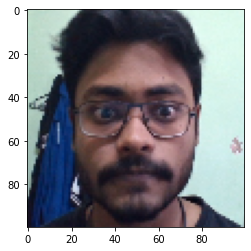

In [278]:
plt.imshow(img)

In [279]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [280]:
data

<ConcatenateDataset shapes: ((), (), ()), types: (tf.string, tf.string, tf.float32)>

In [281]:
sample = data.as_numpy_iterator()

In [282]:
print(sample.next())

(b'data\\anchor\\db1985a2-d461-11ed-9235-e4aaea77320a.jpg', b'data\\positive\\186727b6-d462-11ed-b044-e4aaea77320a.jpg', 1.0)


In [283]:
example=sample.next()

In [284]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [285]:
res = preprocess_twin(*example)

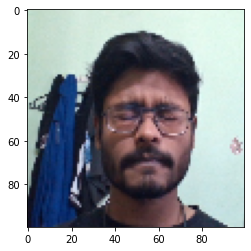

In [288]:
plt.imshow(res[1])

In [287]:
res[2]

1.0

In [289]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [290]:
data

<ShuffleDataset shapes: ((100, 100, None), (100, 100, None), ()), types: (tf.float32, tf.float32, tf.float32)>

In [291]:
sample = data.as_numpy_iterator()

In [292]:
sample.next()

(array([[[0.76120585, 0.8595784 , 0.7850686 ],
         [0.7455981 , 0.8436373 , 0.7691275 ],
         [0.75681376, 0.854853  , 0.7803432 ],
         ...,
         [0.8902941 , 0.9730392 , 0.937549  ],
         [0.88374513, 0.96649027, 0.93100005],
         [0.8773432 , 0.9640098 , 0.9167549 ]],
 
        [[0.7542059 , 0.8600882 , 0.7867549 ],
         [0.74228424, 0.8481666 , 0.7814999 ],
         [0.76034313, 0.8544608 , 0.7917157 ],
         ...,
         [0.8725    , 0.9744608 , 0.9234804 ],
         [0.8639901 , 0.96595097, 0.9149706 ],
         [0.8633333 , 0.9652941 , 0.9221568 ]],
 
        [[0.7661274 , 0.86950976, 0.8036765 ],
         [0.7514216 , 0.8573039 , 0.79063725],
         [0.74313724, 0.8490196 , 0.7887255 ],
         ...,
         [0.8507353 , 0.9605392 , 0.90563726],
         [0.85161763, 0.96142155, 0.9065196 ],
         [0.8608824 , 0.9706863 , 0.9233334 ]],
 
        ...,
 
        [[0.07892157, 0.06691176, 0.13318628],
         [0.10294118, 0.06176471, 0.12769

In [293]:
len(sample.next())

3

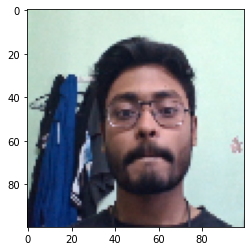

In [294]:
plt.imshow(sample.next()[0])

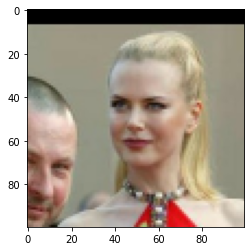

In [295]:
plt.imshow(sample.next()[1])

In [296]:
sample.next()[2]

0.0

In [297]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)
#16 16 ke batch mai baant diya hai 

In [298]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8) 

In [132]:
round(len(data)*.3)

180

In [133]:
round(len(data)*.7)

420

In [103]:
###################################################

In [299]:
#first is to embed the pic in multiple layer acc to siamese then bring in flatten model 
def make_embedding():
    inp = Input(shape=(100,100,3), name='input_image')
    
    #first block
    c1= Conv2D(64,(10,10),activation='relu')(inp) #64 is filter layer and 10 is pixel
    m1= MaxPooling2D(64,(2,2),padding='same')(c1)
    
      # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)  # the numb are from siamese
    f1= Flatten()(c4)
    d1= Dense(4096,activation='sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [ ]:
256*4*4

In [300]:
embedding = make_embedding()

In [301]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 9, 9, 128)         0 

In [302]:
# will be making distance layer which says the distance between both rivers 
# Siamese L1 Distance class

@tf.keras.utils.register_keras_serializable()
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [303]:
l1 = L1Dist()

In [306]:
l1

In [307]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [308]:
siamese_model= make_siamese_model()

In [309]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[0][0]     

In [113]:
#################################################################

In [310]:
#setting up loss
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [311]:
# using adam optimizer (a type of optimizer)
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [ ]:
#In machine learning, a loss function and an optimizer are two essential components that help to improve the performance of a model. A loss function measures the difference between the predicted output of a model and the actual output, while an optimizer adjusts the model's parameters to minimize the loss function.

In [312]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt') #sare checkpoint ke pahale ckpt laga dega 
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [ ]:
#BUILD TRAIN STEP FUN

In [313]:
test_batch = train_data.as_numpy_iterator()

In [314]:
batch_1=test_batch.next()

In [315]:
batch_1

(array([[[[0.78260785, 0.8664706 , 0.8002255 ],
          [0.76862746, 0.8627451 , 0.80784315],
          [0.7513235 , 0.85318625, 0.80220586],
          ...,
          [0.9108333 , 0.98965687, 0.9537745 ],
          [0.8999118 , 0.98246086, 0.9465785 ],
          [0.89509803, 0.98081374, 0.9354313 ]],
 
         [[0.7847255 , 0.87492156, 0.81217647],
          [0.7649706 , 0.85908824, 0.8041863 ],
          [0.77191174, 0.8660294 , 0.8121078 ],
          ...,
          [0.89426476, 0.98053926, 0.93348044],
          [0.89110786, 0.97738236, 0.93032354],
          [0.88235295, 0.9764706 , 0.9254902 ]],
 
         [[0.7726961 , 0.8668138 , 0.80495095],
          [0.7801961 , 0.8743137 , 0.81941175],
          [0.75490195, 0.8490196 , 0.7941176 ],
          ...,
          [0.8901961 , 0.97990197, 0.9311274 ],
          [0.88558817, 0.9797058 , 0.9287254 ],
          [0.8773529 , 0.97313726, 0.9221568 ]],
 
         ...,
 
         [[0.06034314, 0.0559804 , 0.11754902],
          [0.06818

In [316]:
X = batch_1[:2] #leaving the 2nd one i.e., prediction 

In [317]:
y = batch_1[2] # only prediction 

In [318]:
y

array([0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0.],
      dtype=float32)

In [319]:
@tf.function #compiles in calable tensorflow graph 
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:            #tape is like recording everthing on nural network
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)  #applying siamese model
        # Calculate loss
        loss = binary_cross_loss(y, yhat)  #yhat is ypredicted 
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [320]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [321]:
EPOCHS = 50

In [223]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 1061s 40s/step

 Epoch 2/50
27/27 [==============================] - 1279s 47s/step

 Epoch 3/50
27/27 [==============================] - 1521s 57s/step

 Epoch 4/50
27/27 [==============================] - 1318s 49s/step

 Epoch 5/50
27/27 [==============================] - 1353s 50s/step

 Epoch 6/50
27/27 [==============================] - 1291s 48s/step

 Epoch 7/50
27/27 [==============================] - 1256s 47s/step

 Epoch 8/50
27/27 [==============================] - 1137s 42s/step

 Epoch 9/50
27/27 [==============================] - 1232s 46s/step

 Epoch 10/50
27/27 [==============================] - 1183s 43s/step

 Epoch 11/50
27/27 [==============================] - 934s 35s/step

 Epoch 12/50
27/27 [==============================] - 947s 35s/step

 Epoch 13/50
27/

In [322]:
#IMport mertric calculations 
from tensorflow.keras.metrics import Precision, Recall 

In [323]:
#Getting a batch of test data created earlier 
test_input , test_val, y_true = test_data.as_numpy_iterator().next()

In [324]:
 y_true
    

array([1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [325]:
#make prediction 
y_hat = siamese_model.predict([test_input, test_val]) #predict is builtin function 
y_hat

array([[0.49971282],
       [0.49936986],
       [0.49941567],
       [0.49860948],
       [0.4996858 ],
       [0.49974424],
       [0.49720004],
       [0.50031793],
       [0.5002275 ],
       [0.49890274],
       [0.50019366],
       [0.49956307],
       [0.49849296],
       [0.49913332],
       [0.4995449 ],
       [0.4998432 ]], dtype=float32)

In [326]:
#Post processing the results
res = []
for prediction in y_hat:
    if prediction > 0.5:
        res.append(1)
    else:
        res.append(0)

In [229]:
#Other way to do 
[1 if prediction >0.5 else 0 for predition in y_hat]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [327]:
y_true

array([1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [328]:
#creating a metric object
m = Recall()     # or m=Precision()

#calculating the recall value 
m.update_state(y_true,y_hat)
m.result().numpy()
#recall is sare 1000 relevent data mai se kitna fetch kar paye hum 

0.16666667

In [329]:
#creating a metric object
m = Precision()     # or m=Precision()

#calculating the recall value 
m.update_state(y_true,y_hat)
m.result().numpy()
#precision is fetched data mai se kitna relevent hain 

0.33333334

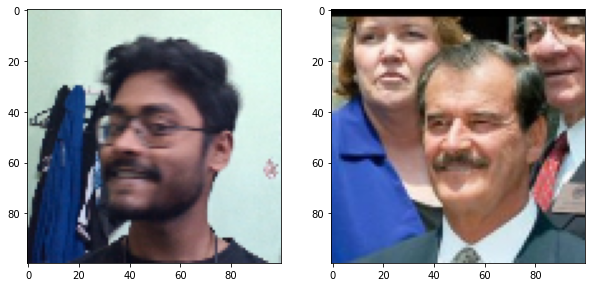

In [330]:
#visualizing the results 
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)   #plt.subplot?? daal ke kya dalna hota hai dek le 
plt.imshow(test_input[15])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[15])

# Renders cleanly
plt.show()

In [192]:
plt.subplot??


In [195]:
#SAVE MODEL 

In [331]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

In [332]:
# Reload model     #used to open h5 tyoe of file 
model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [198]:
tf.keras.models.load_model??

In [333]:
model.predict([test_input,test_val])

array([[0.49971282],
       [0.49936986],
       [0.49941567],
       [0.49860948],
       [0.4996858 ],
       [0.49974424],
       [0.49720004],
       [0.50031793],
       [0.5002275 ],
       [0.49890274],
       [0.50019366],
       [0.49956307],
       [0.49849296],
       [0.49913332],
       [0.4995449 ],
       [0.4998432 ]], dtype=float32)

In [334]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_16 (L1Dist)             (None, 4096)         0           embedding[0][0]     

In [203]:
##################################################################

In [205]:
#Real Time Test 

In [335]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))   #np.expand_dims wraps an array in another array
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) #positive sample jo 50 liya hai 
    verified = verification > verification_threshold
    
    return results, verified

In [207]:
#OPEN CV REAL TIME VERIFICATION 

In [336]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[50:120+250,120:200+250,:]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)


        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.8, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

False


In [337]:
np.sum(np.squeeze(results)>0.5)

2

In [263]:
26/50

0.52